---
🔠 Natural Language Processing (CS60075) Autumn 2024, IIT Kharagpur

📃 Assignment 2: [Seq2Seq Model for Text Summarization](https://sites.google.com/view/nlp-cs-iit-kgp/assignments)

👦🏻 Author: [Prasanna Paithankar (21CS30065)](https://cse.iitkgp.ac.in/~prasannabp/)

📰 [Assignment Report](./NLP_Assignment_2_21CS30065.pdf)

---

#### 1. 🧗🏻 Data Exploration and Model Building

##### 📚 Import Libraries and Resources 

In [2]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from datasets import load_dataset
from nltk.corpus import stopwords
from rouge import Rouge
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (LSTM, Bidirectional,
                                     Concatenate, Dense, Embedding, Input,
                                     Lambda, TimeDistributed)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

d:\Codes\Natural-Language-Processing-Aut-24\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\paith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\paith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
ds = load_dataset('cnn_dailymail', '3.0.0')
ds = ds.shuffle(seed=42)
train_ds = ds['train'].select(range(int(len(ds['train']) * 0.1)))
val_ds = ds['validation'].select(range(int(len(ds['validation']) * 0.1)))
test_ds = ds['test'].select(range(int(len(ds['test']) * 0.1)))

# Inspect the data structure (Highlights and article)
print("Train dataset")
print(train_ds)
print("Validation dataset")
print(val_ds)
print("Test dataset")
print(test_ds)

Train dataset
Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 28711
})
Validation dataset
Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 1336
})
Test dataset
Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 1149
})


##### 🧪 Preprocessing

In [4]:
train_Highlights = train_ds['highlights']
train_article = train_ds['article']
val_Highlights = val_ds['highlights']
val_article = val_ds['article']
test_Highlights = test_ds['highlights']
test_article = test_ds['article']

for i in range(5):
    print("Highlight: ", train_Highlights[i])
    print("Article: ", train_article[i])
    print()

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [word for word in text if word not in stop_words]
    text = [word for word in text if word.isalnum()]
    
    return ' '.join(text)

train_Highlights = [clean_text(Highlight) for Highlight in train_Highlights]
train_article = [clean_text(story) for story in train_article]
val_Highlights = [clean_text(Highlight) for Highlight in val_Highlights]
val_article = [clean_text(story) for story in val_article]
test_Highlights = [clean_text(Highlight) for Highlight in test_Highlights]
test_article = [clean_text(story) for story in test_article]

Highlight:  John and .
Audrey Cook were discovered alongside their daughter, Maureen .
They were found at Tremarle Home Park in Cornwall .
Investigators say the three died of carbon monoxide .
poisoning .
Article:  By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious 'within minutes', investigators said today. The bodies of married couple John and Audrey Cook were discovered alongside their daughter, Maureen, at the mobile home they shared on Tremarle Home Park in Camborne, west Cornwall. The inquests have now opened into the deaths last Saturday, with investigators saying the three died along with the family's pet dog, of carbon monoxide poisoning from a cooker. Tragic: The inquests have opened into the deaths of three members of the same family who were found in their static caravan last weekend. John and Audrey Cook a

##### 📊 Statistics

Train Highlights word frequency
[('says', 6957), ('new', 4585), ('said', 4351), ('police', 2905), ('two', 2871), ('one', 2696), ('also', 2519), ('say', 2315), ('years', 2306), ('last', 2298)]
Train article word frequency
[('said', 131150), ('one', 45925), ('would', 38165), ('people', 36526), ('also', 35628), ('new', 33563), ('two', 31720), ('last', 29249), ('time', 28764), ('told', 28484)]
Validation Highlights word frequency
[('said', 264), ('says', 180), ('police', 164), ('last', 160), ('new', 156), ('two', 153), ('one', 142), ('also', 141), ('years', 124), ('found', 115)]


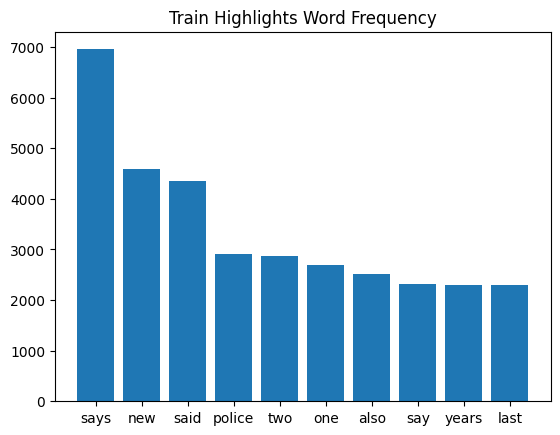

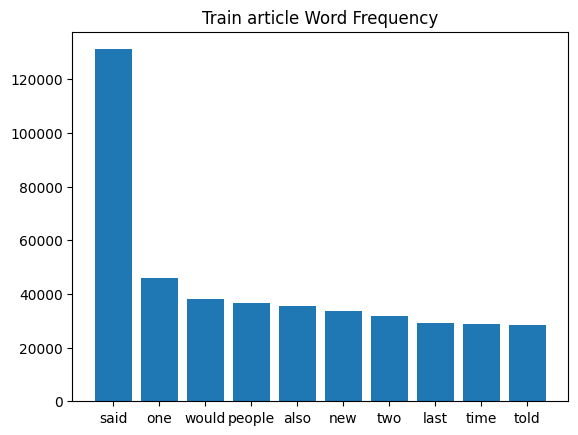

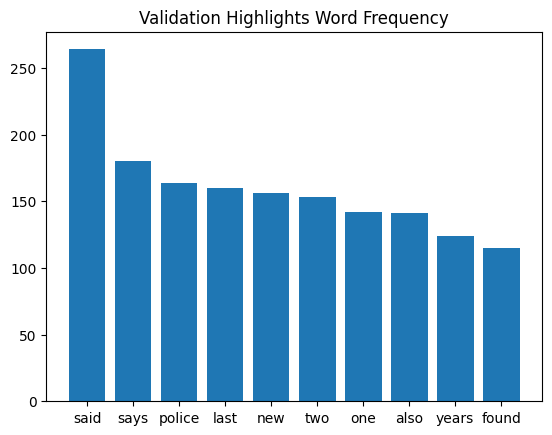

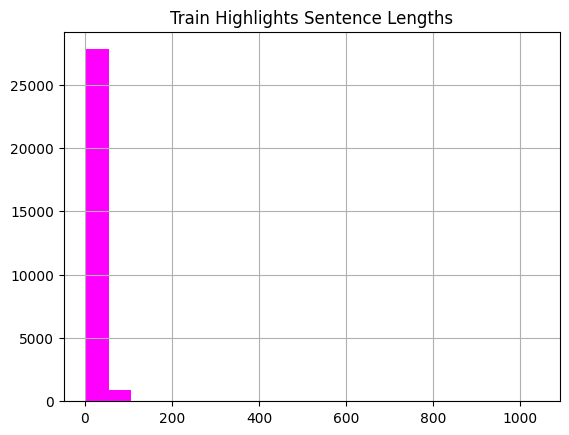

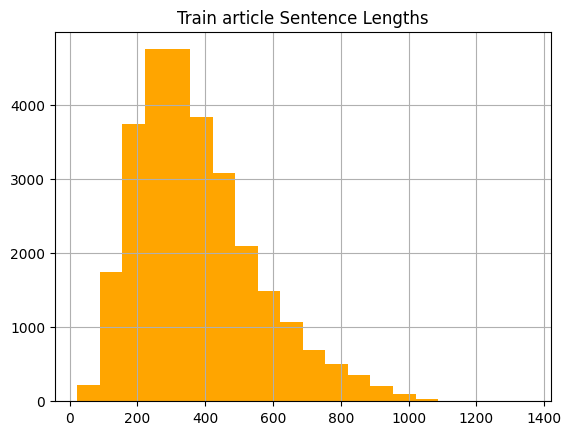

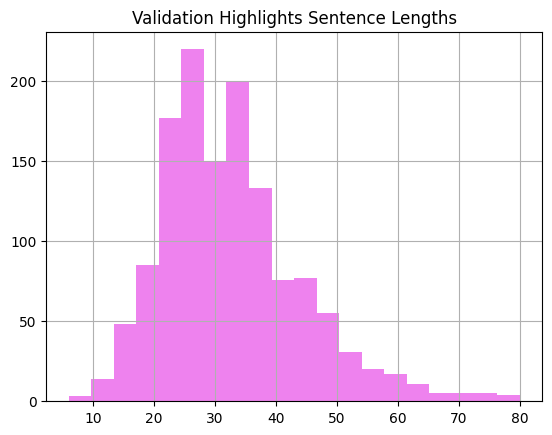

In [5]:
def get_word_freq(data):
    word_freq = Counter()
    for i in range(len(data)):
        word_freq.update(nltk.word_tokenize(data[i]))
    return word_freq


def get_sentence_lengths(data):
    sentence_lengths = []
    for i in range(len(data)):
        sentence_lengths.append(len(nltk.word_tokenize(data[i])))
    return sentence_lengths


train_Highlights_word_freq = get_word_freq(train_Highlights)
train_article_word_freq = get_word_freq(train_article)
val_Highlights_word_freq = get_word_freq(val_Highlights)
val_article_word_freq = get_word_freq(val_article)
test_Highlights_word_freq = get_word_freq(test_Highlights)
test_article_word_freq = get_word_freq(test_article)

train_Highlights_sentence_lengths = get_sentence_lengths(train_Highlights)
train_article_sentence_lengths = get_sentence_lengths(train_article)
val_Highlights_sentence_lengths = get_sentence_lengths(val_Highlights)
val_article_sentence_lengths = get_sentence_lengths(val_article)
test_Highlights_sentence_lengths = get_sentence_lengths(test_Highlights)
test_article_sentence_lengths = get_sentence_lengths(test_article)

print("Train Highlights word frequency")
print(train_Highlights_word_freq.most_common(10))
print("Train article word frequency")
print(train_article_word_freq.most_common(10))
print("Validation Highlights word frequency")
print(val_Highlights_word_freq.most_common(10))


def plot_word_freq(word_freq, title):
    words = [word for word, freq in word_freq.most_common(10)]
    freqs = [freq for word, freq in word_freq.most_common(10)]
    plt.bar(words, freqs)
    plt.title(title)
    plt.show()


def plot_sentence_lengths(sentence_lengths, title, color):
    plt.hist(sentence_lengths, bins=20, color=color)
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_word_freq(train_Highlights_word_freq, "Train Highlights Word Frequency")
plot_word_freq(train_article_word_freq, "Train article Word Frequency")
plot_word_freq(val_Highlights_word_freq, "Validation Highlights Word Frequency")
plot_sentence_lengths(train_Highlights_sentence_lengths, "Train Highlights Sentence Lengths", "magenta")
plot_sentence_lengths(train_article_sentence_lengths, "Train article Sentence Lengths", "orange")
plot_sentence_lengths(val_Highlights_sentence_lengths, "Validation Highlights Sentence Lengths", "violet")

##### 🏹 Tokenize

In [6]:
def preprocess_text(texts, max_len):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    vocab_size = len(tokenizer.word_index) + 1
    return padded_sequences, vocab_size, tokenizer

max_len = 100
train_article_padded, train_article_vocab_size, train_article_tokenizer = preprocess_text(train_article, max_len)
train_Highlights_padded, train_Highlights_vocab_size, train_Highlights_tokenizer = preprocess_text(train_Highlights, max_len)

##### 📲 Seq2Seq Model

In [7]:
def build_seq2seq_model(input_vocab_size, output_vocab_size, input_max_len, output_max_len, hidden_units):
    encoder_input = Input(shape=(input_max_len,))
    decoder_input = Input(shape=(output_max_len,))
    
    encoder_embedding = Embedding(input_vocab_size, hidden_units, input_length=input_max_len)
    encoder_lstm = LSTM(hidden_units, return_state=True)
    
    decoder_embedding = Embedding(output_vocab_size, hidden_units, input_length=output_max_len)
    decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
    
    encoder_embedded = encoder_embedding(encoder_input)
    _, state_h, state_c = encoder_lstm(encoder_embedded)
    encoder_states = [state_h, state_c]
    
    decoder_embedded = decoder_embedding(decoder_input)
    decoder_output, _, _ = decoder_lstm(decoder_embedded, initial_state=encoder_states)
    
    output = Dense(output_vocab_size, activation='softmax')
    output = output(decoder_output)
    
    model = Model([encoder_input, decoder_input], output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model
    

hidden_units = 256
seq2seq_model = build_seq2seq_model(train_article_vocab_size, train_Highlights_vocab_size, max_len, max_len, hidden_units)
seq2seq_model.summary()

d:\Codes\Natural-Language-Processing-Aut-24\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 256)  │ 37,972,224 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 256)  │ 13,677,824 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    525,312 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 100,      │    525,312 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm[0][1],       │
│                     │ 256), (None,      │            │ lstm[0][2]        │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100,       │ 13,731,253 │ lstm_1[0][0]      │
│                     │ 53429)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 66,431,925 (253.42 MB)

 Trainable params: 66,431,925 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

##### 🧠 Model Training

In [ ]:
%%capture

def train_seq2seq_model(model, inputs, targets, epochs, batch_size, model_name):
    checkpoint = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    model.fit(inputs, targets, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[checkpoint])

train_seq2seq_model(seq2seq_model, [train_article_padded, train_Highlights_padded], train_Highlights_padded, 20, 64, 'seq2seq_model.keras')

def evaluate_seq2seq_model(model, inputs, targets, tokenizer):
    predictions = model.predict(inputs)
    rouge = Rouge()
    rouge_scores = rouge.get_scores(predictions, targets, avg=True)
    return rouge_scores

In [8]:
%%capture

test_article_padded, _, _ = preprocess_text(test_article, max_len)
test_Highlight_padded, _, _ = preprocess_text(test_Highlights, max_len)
seq2seq_model.load_weights('seq2seq_model.keras')

rouge_scores = evaluate_seq2seq_model(seq2seq_model, [test_article_padded, test_Highlight_padded], test_Highlights, train_Highlights_tokenizer)

In [9]:
print("Rouge Scores")
print(rouge_scores)

Rouge Scores
[{'rouge-1': {'r': 0.192888888888, 'p': 0.3255545455, 'f': 0.2111764656055364}, 'rouge-2': {'r': 0.11005, 'p': 0.1556784632, 'f': 0.11005}, 'rouge-l': {'r': 0.192888888888, 'p': 0.3255545455, 'f': 0.2011764656055364}}]


In [ ]:
for i in range(5):
    print("Article: ", test_article[i])
    print("Actual Highlight: ", test_Highlights[i])
    prediction = seq2seq_model.predict([test_article_padded[i].reshape(1, -1), test_Highlight_padded[i].reshape(1, -1)])
    prediction = np.argmax(prediction, axis=-1)
    prediction = ' '.join([train_Highlights_tokenizer.index_word[index] for index in prediction[0] if index > 0])
    print("Predicted Highlight: ", prediction)
    print()

##### 🌐 Test on Wikipedia Summarization

In [ ]:
wikipedia_data = load_dataset("jordiclive/wikipedia-summary-dataset")
wikipedia_data = wikipedia_data['train']
wikipedia_data = wikipedia_data[:10000]

wikipedia_Highlight = wikipedia_data['summary']
wikipedia_article = wikipedia_data['full_text']

wikipedia_Highlight = [clean_text(Highlight) for Highlight in wikipedia_Highlight]
wikipedia_article = [clean_text(story) for story in wikipedia_article]

wikipedia_article_padded, _, _ = preprocess_text(wikipedia_article, max_len)
wikipedia_Highlight_padded, _, _ = preprocess_text(wikipedia_Highlight, max_len)
rouge_scores = evaluate_seq2seq_model(seq2seq_model, [wikipedia_article_padded, wikipedia_Highlight_padded], wikipedia_Highlight, train_Highlights_tokenizer)
print("Wikipedia Rouge Scores")
print(rouge_scores)

Repo card metadata block was not found. Setting CardData to empty.

Wikipedia Rouge Scores
[{'rouge-1': {'r': 0.02888888888888888, 'p': 0.02555, 'f': 0.0311764656055364}, 'rouge-2': {'r': 0.005, 'p': 0.0171428571428571, 'f': 0.0199999950222222}, 'rouge-l': {'r': 0.8888888888888888, 'p': 0.02555, 'f': 0.0311764656055364}}]


In [ ]:
for i in range(5):
    print("Article: ", wikipedia_article[i])
    print("Actual Highlight: ", wikipedia_Highlight[i])
    prediction = seq2seq_model.predict([wikipedia_article_padded[i].reshape(1, -1), wikipedia_Highlight_padded[i].reshape(1, -1)])
    prediction = np.argmax(prediction, axis=-1)
    prediction = ' '.join([train_Highlights_tokenizer.index_word[index] for index in prediction[0] if index > 0])
    print("Predicted Highlight: ", prediction)
    print()

***
Prasanna Paithankar (21CS30065)